##### **Background Objective:**

<br>

A prototype of image semantic segmentation model was developed to test the performances on detecting the defects of manufactured steels in high-resolution images, sourced from the Kaggle competition dataset accessible at: https://www.kaggle.com/competitions/severstal-steel-defect-detection. In the dataset, there were around 6,600 images with at least one of the four annotated types of defects. Among them, over 5,000 images consisted of type 3 defect, while the other defects respectively appeared in less than 1,000 images. Additionally, around 5,000 images without any type of defect identified were retained as control samples (negative class). The objective was to train a model that could capture the pixels of defects and attribute them into correct defective types.

<br>

##### **Data Preprocessing:**

<br>

The raw images were of 256 x 1600 pixels, while the masks were denoted with RLE (run-length encoding). Due to the multi-label characteristic of the outputs (different types of defects could co-occur in the same image), the decoded images would be of 5 layers of concatenated masks (4 defect classes + 1 class indicating no defect), in the style of one-hot encoding. For memory concern givven a 16 GB VRAM GPU processor, the inputted image were preprocessed to scale down to 64 x 400 dimensions. 

To handle the class imbalance problem, keeping the ratio of approximately equal proportions considering the most infrequent class with existence in only around 200 images, the other classes were randomly down-sampled accordingly with different percentages. Then, data augmentation was applied to the sampled images, mainly through rotating and flipping the defected positions, to increase the number of samples of the three minority defect classes. Another 200 sampled images from the non-defected class were added, eventually making a truncated dataset of 2,200 images, to which the testing model would be applied.

<br>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import seaborn
import random
import imageio
import torch
import os
import json

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score

In [ ]:
from torch.utils import data
## use pytorch data loader for reading image into arrays
class read_image_data(data.Dataset):
    def __init__(self, root_path, img_list):
        self.root_path = root_path
        self.img_list = img_list
    def __getitem__(self, index):
        imgID = self.img_list[index]
        image_path = os.path.join(self.root_path, imgID + '.jpg')
        image = np.array(imageio.imread(image_path), dtype=np.uint8)
        return image
    def __len__(self):
        return len(self.img_list)

In [ ]:
train_list = pd.read_csv('train.csv')
train_path = './train_images/'
sample_list = sorted(list(set([str(x).split(".")[0] for x in train_list['ImageId'].values])))
df = read_image_data(train_path, sample_list)

In [ ]:
train_list

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


In [ ]:
## proportion of different classes
print(collections.Counter(train_list['ClassId']))
print([(x[0], round(x[1] / len(set(train_list['ImageId'])), 4)) for x in collections.Counter(train_list['ClassId']).items()])

Counter({3: 5150, 1: 897, 4: 801, 2: 247})
[(1, 0.1346), (3, 0.7726), (4, 0.1202), (2, 0.0371)]


In [ ]:
## number of training images
print("Num_of_samples:")
print(len(df))
## shape of each training image
print("Height, Width, Num_of_channels:")
print(df[0].shape)

Num_of_samples:
6666
Height, Width, Num_of_channels:
(256, 1600, 3)


In [ ]:
## Splitting ImageID, and then transform ClassID to defect class indicators
train_df = pd.pivot(train_list, values='EncodedPixels', index='ImageId', columns='ClassId')
train_df = train_df.reset_index()

class_array = np.zeros((len(train_df), 4))
for i in range(len(train_df)):
    for c in range(4):
        if pd.isna(train_df.iloc[i, c+1]):
            class_array[i,c] = 0
        else:
            class_array[i,c] = 1

train_df = pd.concat([train_df, pd.DataFrame(class_array)], axis=1)
train_df.columns = ['ImageID','Defect_Loc_1','Defect_Loc_2','Defect_Loc_3','Defect_Loc_4',
                    'Class_1','Class_2','Class_3','Class_4']

In [ ]:
## Mask running-length encoded strings to pixel matrices
def rle_decoder(rleString, height, width):
    rows, cols = height, width
    ## break rle encoding into pixel and length mapping pairs
    rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
    rlePairs = np.array(rleNumbers).reshape(-1,2)
    ## encode the defect location matrix of the image pixels
    ## first decoding an 1-d array
    steel_defect = np.zeros((cols*rows), dtype=np.uint8)
    for pixel_index, run_length in rlePairs:
        ## 1st pixel at (1,1), minus 1 to fit in numpy array indexing
        pixel_index -= 1
        steel_defect[pixel_index:(pixel_index + run_length)] = 255
    ## pixels are numbered from top to bottom, then left to right; 
    ## reshape and transpose to get correct position
    steel_defect = steel_defect.reshape(cols, rows)
    steel_defect = steel_defect.T
    
    return steel_defect

In [ ]:
# add a column in the training set that converts the running length encoded values to vectorized feature
for i in range(4):
  train_df['rle_masked_def_loc' + str(i+1)] = train_df.iloc[:,i+1].apply(
                                              lambda x: np.nan if pd.isna(x)
                                                        else rle_decoder(x, df[0].shape[0], df[0].shape[1]))

In [ ]:
## print dataset
train_df[0:20]

,ImageID,Defect_Loc_1,Defect_Loc_2,Defect_Loc_3,Defect_Loc_4,Class_1,Class_2,Class_3,Class_4,rle_masked_def_loc1,rle_masked_def_loc2,rle_masked_def_loc3,rle_masked_def_loc4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,NaN,NaN,NaN,1.0,0.0,0.0,0.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",NaN,NaN,NaN
1,0007a71bf.jpg,NaN,NaN,18661 28 18863 82 19091 110 19347 110 19603 11...,NaN,0.0,0.0,1.0,0.0,NaN,NaN,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",NaN
2,000a4bcdd.jpg,37607 3 37858 8 38108 14 38359 20 38610 25 388...,NaN,NaN,NaN,1.0,0.0,0.0,0.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",NaN,NaN,NaN
3,000f6bf48.jpg,NaN,NaN,NaN,131973 1 132228 4 132483 6 132738 8 132993 11 ...,0.0,0.0,0.0,1.0,NaN,NaN,NaN,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,0014fce06.jpg,NaN,NaN,229501 11 229741 33 229981 55 230221 77 230468...,NaN,0.0,0.0,1.0,0.0,NaN,NaN,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",NaN
5,0025bde0c.jpg,NaN,NaN,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...,315139 8 315395 15 315651 16 315906 17 316162 ...,0.0,0.0,1.0,1.0,NaN,NaN,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
6,002af848d.jpg,NaN,NaN,NaN,290800 6 291055 13 291311 15 291566 18 291822 ...,0.0,0.0,0.0,1.0,NaN,NaN,NaN,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
7,002fc4e19.jpg,146021 3 146275 10 146529 40 146783 46 147038 ...,145658 7 145901 20 146144 33 146386 47 146629 ...,NaN,NaN,1.0,1.0,0.0,0.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",NaN,NaN
8,0030401a5.jpg,NaN,NaN,NaN,186833 1 187089 3 187344 6 187600 7 187855 10 ...,0.0,0.0,0.0,1.0,NaN,NaN,NaN,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
9,0046839bd.jpg,NaN,NaN,152926 1 153180 4 153434 6 153689 8 153943 11 ...,NaN,0.0,0.0,1.0,0.0,NaN,NaN,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",NaN


In [ ]:
## decode segmentation mask
semantic_masks = []
for i in range(train_df.shape[0]):
    ## initialize semantic image
    sem_img = np.zeros((256, 1600, 3), dtype=np.uint8)
    ## assign one color for each class
    color_code = {1: np.array([128,64,128]),
                  2: np.array([190,250,190]),
                  3: np.array([254,228,12]),
                  4: np.array([28,42,168])}
    for j in range(1, 5):
        if train_df['Class_' + str(j)].iloc[i] == 1:
            mat = train_df['rle_masked_def_loc' + str(j)].iloc[i]
            ind = np.vstack(np.where(mat > 0)).T.tolist()
            for t in ind:
                sem_img[t[0],t[1],:] = color_code[j]
    semantic_masks.append(sem_img)

In [ ]:
## check the extent of unbalanced training dataset
c = train_df[['Class_1','Class_2','Class_3','Class_4']]
c1 = c[(c['Class_1'] == 1) & (c['Class_3'] == 0)]
c2 = c[(c['Class_2'] == 1) & (c['Class_3'] == 0)]
c3 = c[c['Class_3'] == 1]
c4 = c[(c['Class_4'] == 1) & (c['Class_3'] == 0)]

In [ ]:
print(c1.shape)
print(c2.shape)
print(c3.shape)
print(c4.shape)

(804, 4)
(231, 4)
(5150, 4)
(517, 4)


In [ ]:
## subsample (scale down the non-minority classes)
subc1 = c1.sample(n = 200)
subc2 = c2.sample(n = 200)
subc3 = c3.sample(n = 500)
subc4 = c4.sample(n = 200)
c_sample = pd.concat([subc1, subc2, subc3, subc4], axis = 0)
train_df_sample = train_df.iloc[c_sample.index,:]

In [ ]:
## data augmentation for class 1, 2, 4
aug_id = train_df[['ImageID','Class_1','Class_2','Class_3','Class_4','rle_masked_def_loc1','rle_masked_def_loc2','rle_masked_def_loc3','rle_masked_def_loc4']]
aug_id = aug_id[(aug_id['Class_1'] == 1) | (aug_id['Class_2'] == 1) | (aug_id['Class_4'] == 1)]
aug_id = aug_id[aug_id['Class_3'] == 0]
aug_id_list = sorted(list(set([str(x).split(".")[0] for x in aug_id['ImageID'].values])))
aug_id = aug_id.reset_index(drop=True)

## rotation and flipping
aug_img_src = [df[x] for x in list(aug_id.index)]
aug_img_1 = [np.flip(x, axis = 0) for x in aug_img_src]
aug_img_2 = [np.flip(x, axis = 1) for x in aug_img_src]
aug_img_3 = [x[::-1,::-1] for x in aug_img_src]

## 100 images x 3 classes x 3 augmentation sets
a = aug_id[['Class_1','Class_2','Class_3','Class_4']]
a1 = a[(a['Class_1'] == 1)]
a2 = a[(a['Class_2'] == 1)]
a4 = a[(a['Class_4'] == 1)]
suba1 = a1.sample(n = 100)
suba2 = a2.sample(n = 100)
suba4 = a4.sample(n = 100)
a_sample = pd.concat([suba1, suba2, suba4], axis = 0)
aug_df_sample = aug_id.iloc[a_sample.index,:]

In [ ]:
## get segmentation masks for augmented data samples
aug_semantic_masks_1 = []
aug_semantic_masks_2 = []
aug_semantic_masks_3 = []
for i in range(aug_id.shape[0]):
    ## initialize semantic image
    sem_img = np.zeros((256, 1600, 3), dtype=np.uint8)
    ## assign one color for each class
    color_code = {1: np.array([128,64,128]),
                  2: np.array([190,250,190]),
                  3: np.array([254,228,12]),
                  4: np.array([28,42,168])}
    for j in range(1, 5):
        if aug_id['Class_' + str(j)].iloc[i] == 1:
            mat = aug_id['rle_masked_def_loc' + str(j)].iloc[i]
            ind = np.vstack(np.where(mat > 0)).T.tolist()
            for t in ind:
                sem_img[t[0],t[1],:] = color_code[j]
    sem_img_1 = np.flip(sem_img, axis = 0)
    sem_img_2 = np.flip(sem_img, axis = 1)
    sem_img_3 = sem_img[::-1,::-1,:]
    aug_semantic_masks_1.append(sem_img_1)
    aug_semantic_masks_2.append(sem_img_2)
    aug_semantic_masks_3.append(sem_img_3)

In [ ]:
print(len(aug_semantic_masks_1))
print(len(aug_semantic_masks_2))
print(len(aug_semantic_masks_3))
print(aug_semantic_masks_1[0].shape)
print(aug_semantic_masks_2[0].shape)
print(aug_semantic_masks_3[0].shape)

1516
1516
1516
(256, 1600, 3)
(256, 1600, 3)
(256, 1600, 3)


In [ ]:
## sample 200 black image (negative samples with no defect)
control_list = [x.split(".")[0] for x in os.listdir('./train_images/') if x.split(".")[0] not in sample_list]
control_list = random.choices(control_list, k=200)
df_control = read_image_data(train_path, control_list)
control_mask = [np.zeros((256,1600,3), dtype=np.uint8) for n in range(200)]

In [ ]:
## sampling results
df_sample = [df[x] for x in list(train_df_sample.index)]
semantic_masks = [semantic_masks[x] for x in list(train_df_sample.index)]
subsample_list = [sample_list[x] for x in list(train_df_sample.index)]
aug_img_1 = [aug_img_1[x] for x in aug_df_sample.index]
aug_img_2 = [aug_img_2[x] for x in aug_df_sample.index]
aug_img_3 = [aug_img_3[x] for x in aug_df_sample.index]
aug_semantic_masks_1 = [aug_semantic_masks_1[x] for x in list(aug_df_sample.index)]
aug_semantic_masks_2 = [aug_semantic_masks_2[x] for x in list(aug_df_sample.index)]
aug_semantic_masks_3 = [aug_semantic_masks_3[x] for x in list(aug_df_sample.index)]

In [ ]:
aug_id_list_1 = [aug_id_list_1[x] for x in list(aug_df_sample.index)]
aug_id_list_2 = [aug_id_list_2[x] for x in list(aug_df_sample.index)]
aug_id_list_3 = [aug_id_list_3[x] for x in list(aug_df_sample.index)]

In [ ]:
class convert_augmented_image_data(data.Dataset):
    def __init__(self, data, img_list):
        self.data = data
        self.img_list = img_list
    def __getitem__(self, index):
        imgID = self.img_list[index]
        image = self.data[index]
        return image
    def __len__(self):
        return len(self.img_list)

In [ ]:
df_aug_img_1 = convert_augmented_image_data(aug_img_1, aug_id_list_1)
df_aug_img_2 = convert_augmented_image_data(aug_img_2, aug_id_list_2)
df_aug_img_3 = convert_augmented_image_data(aug_img_3, aug_id_list_3)

In [ ]:
df_mask = convert_augmented_image_data(semantic_masks, subsample_list)
df_control_mask = convert_augmented_image_data(control_mask, control_list)
df_aug_mask_1 = convert_augmented_image_data(aug_semantic_masks_1, aug_id_list_1)
df_aug_mask_2 = convert_augmented_image_data(aug_semantic_masks_2, aug_id_list_2)
df_aug_mask_3 = convert_augmented_image_data(aug_semantic_masks_3, aug_id_list_3)

In [ ]:
## concatenate raw data, augmented data, control data
df_train = torch.utils.data.ConcatDataset([df_sample, df_aug_img_1, df_aug_img_2, df_aug_img_3, df_control])
## concatenate raw data, augmented data, control data
mask_train = torch.utils.data.ConcatDataset([df_mask, df_aug_mask_1, df_aug_mask_2, df_aug_mask_3, df_control_mask])

In [ ]:
## number of training samples for testing
print(len(df_train))

2200


In [ ]:
## breakdown of training samples
print(len(df_mask))
print(len(df_aug_mask_1))
print(len(df_aug_mask_2))
print(len(df_aug_mask_3))
print(len(df_control_mask))

1100
300
300
300
200


##### **Visualizing the raw images and masks:**

<br>

From below, the paired raw images and the annotated defect segmentation masks presented by different colours were plotted out in serial order alternately (image first and followed by mask). The first 4 pairs showed the same image and mask sample while the latter three were augmented from the first one by rotation and flipping. Worth-mentioning for the last image-mask pair shown, the comparison of taking normalization and without normalization was illustrated. Usually image normalization would be considered for some image segmentation tasks, but for this task, the normalization experimentally made the model more difficult in learning the patterns. Hence, the normalization step was skipped in the data loading function.

<br>

##### **Training-Validation-Testing splits and targeted measurement:**

<br>

With trimming down to 2,200 images, it would be around one-sixth of the entire dataset. 20% of the 2,200 images were reserved as the testing dataset, and 10% of the remaining (8% of all) would be used as validation samples during training. The training samples included 1,584 images. The targeted measurement to achieve in this project was the dice coefficient, which determines the extent of intersection between the predicted segmented pixels and the true segmentation pixels, following a formula of:

\begin{align}
        Dice = 2 * \frac{X \cap Y}{X + Y}\
    \end{align}

<br>

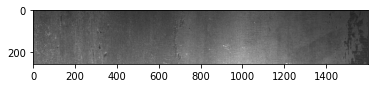

In [ ]:
plt.imshow(df[0])

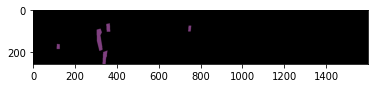

In [ ]:
plt.imshow(semantic_masks[0])

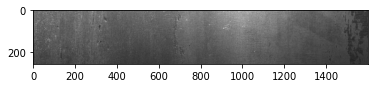

In [ ]:
plt.imshow(aug_img_1[0])

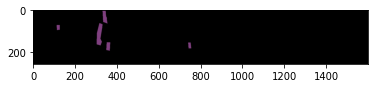

In [ ]:
plt.imshow(aug_semantic_masks_1[0])

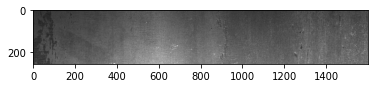

In [ ]:
plt.imshow(aug_img_2[0])

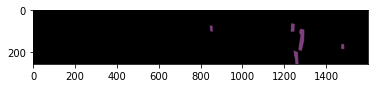

In [ ]:
plt.imshow(aug_semantic_masks_2[0])

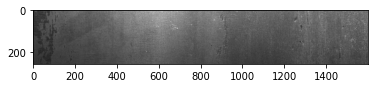

In [ ]:
plt.imshow(aug_img_3[0])

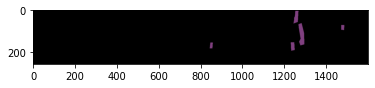

In [ ]:
plt.imshow(aug_semantic_masks_3[0])

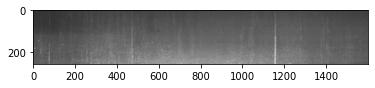

In [ ]:
plt.imshow(df[1])

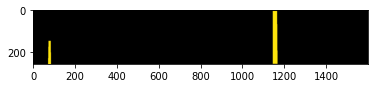

In [ ]:
plt.imshow(semantic_masks[1])

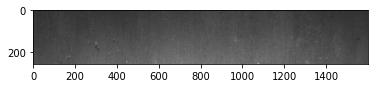

In [ ]:
plt.imshow(df[2])

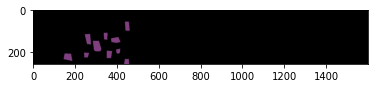

In [ ]:
plt.imshow(semantic_masks[2])

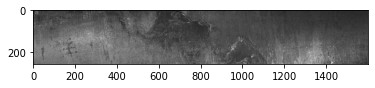

In [ ]:
plt.imshow(df[3])

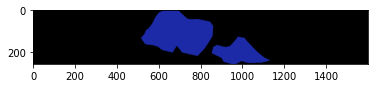

In [ ]:
plt.imshow(semantic_masks[3])

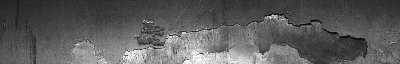

In [ ]:
transforms.ToPILImage()(df_train['train'][0][0])

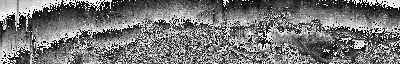

In [ ]:
## Normalization (Mean, SD) taken
transforms.ToPILImage()(df_train['train'][0][0])

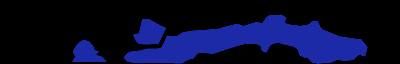

In [ ]:
## No Normalization (Mean, SD) taken
transforms.ToPILImage()(df_train['train'][0][1])

In [ ]:
def dataset_split(dataset, val_split=0.2):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = torch.utils.data.Subset(dataset, train_idx)
    datasets['test'] = torch.utils.data.Subset(dataset, val_idx)
    return datasets, (train_idx, val_idx)

## splitting training and testing sets
df_train, split_indx = dataset_split(df_train)

In [ ]:
print(len(df_train['train']))
print(len(df_train['test']))

1760
440


In [ ]:
## generate a transformed dataset for images and targets
from torchvision import transforms
from torch.utils import data

class transformed_data(data.Dataset):
    def __init__(self, img_path, mask_path):
        self.img = img_path    
        self.mask = mask_path

    def __getitem__(self, index):
        ## loading
        ls_img = sorted(os.listdir(self.img))
        ls_mask = sorted(os.listdir(self.mask))
        img_file_path = os.path.join(self.img, ls_img[index])
        img_tensor = torch.load(img_file_path)
        mask_file_path = os.path.join(self.mask, ls_mask[index])
        mask_numpy = torch.load(mask_file_path)
        mask_numpy = transforms.ToPILImage()(mask_numpy)
        mask_numpy = np.array(mask_numpy)
        ## normalization
        mean = transforms.ToTensor()(img_tensor).mean([1,2])
        std = transforms.ToTensor()(img_tensor).std([1,2])
        ## ToTensor() = scaled to 1/255
        ## Normalize = scaled to -1 to 1
        colors = np.array([[128,64,128],
                           [190,250,190],
                           [254,228,12],
                           [28,42,168]])
        ohe = np.zeros((*mask_numpy.shape[:2], len(colors)))
        for label, color in enumerate(colors):
            v = np.zeros(len(colors))
            v[label] = 1
            ohe[np.all(mask_numpy == color, axis=-1)] = v
        ## 5 masks
        negative_mask = np.zeros((*mask_numpy.shape[:2], 1))
        negative_mask[np.sum(ohe, axis = 2) == 0] = 1
        ohe = np.concatenate((ohe, negative_mask), axis = 2)
        img_norm = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(64),
                    ## transforms.Normalize(mean, std)
        ])
        img_tensor = img_norm(img_tensor)
        mask_norm = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(64)
        ])
        mask_tensor = mask_norm(ohe)
        mask_tensor[mask_tensor > 0] = 1
        return img_tensor, mask_tensor

    def __len__(self):
        return len(os.listdir(self.img))

In [ ]:
df_train = transformed_data(img_path = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/steel defects segmentation/steel_image/subsample/train/',
                            mask_path = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/steel defects segmentation/steel_image/subsample/train_mask/')

In [ ]:
def dataset_split(dataset, val_split=0.1, random_state=None):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split, random_state=random_state)
    datasets = {}
    datasets['train'] = torch.utils.data.Subset(dataset, train_idx)
    datasets['val'] = torch.utils.data.Subset(dataset, val_idx)
    return datasets

In [ ]:
df_train = dataset_split(df_train, random_state=42)

##### **Model Design Thinking:**

<br>

**1)  U-Net:**

<br>

U-net with skip connection structure was proven to be successful tackling image segmentation problems. A number of variants combining the design features of other models like the residual short-circuiting mechanism in the ResNet and branched convolutions of different sized kernels in the Inception networks. The model to be tested also implemented both of these two designs in the convolution and deconvolution blocks. 

For the details of the convolution block, it consisted of 6 branches divided into 3 groups: the first group was applying square kernels of sizes of 3x3 and 5x5, the second group would be trying to capture vertical significance of features with kernels of 3x1 and 5x1, the third group would be horizontally-focused constituted of 1x3 and 1x5 kernels. Respectively, 1x1 convolution would be performed before entering all 3 grouped channels to project the depths of features into a higher dimension. The outputs of the two convolutions in one single group of branches would be concatenated, followed by another 1x1 convolution layer served like a drop-out of the features to truncate the depths. Grouped convolution (as against entire convolution permeating through each feature map) would be conducted to reduce connection parameter density preserving the nature of two combined sources of learned features. Similarly, the 3 grouped outputs were concatenated and group convolution was applied again afterwards. 

The final step in the convolution module would depend, if it was performing a structure analogous to a ResNet module, then the element-wise addition would require the same depth as the input, subsequent 1x1 convolution layers would be placed to scale down the depth of the output from the grouped convolution, if the activated output would be of different depth from the inputted depth, a 1x1 convolution would be applied to the original input to give a depth aligned to the output from the grouped convolution. A concpetual diagram of a block could be referred below.

The use of a mixture of 3x3 and 5x5 kernels would be mimicking Inception module to automatically select features from different-sized kernels. To extend the convolution module, more branches could be added like 7x7 kernels, or stacking 3x3 convolution and 5x5 convolution together making a deeper branch, or doing max-pooling before convolutions. 

The U-Net model consisted of 4 layers of convolution blocks, in which each of the outputs activated would be skip-connected to the deconvolution blocks where same designs of branched and grouped convolutions were applied. In each convolution layer, two stacked blocks were deployed, while in each deconvolution layer, 3 stacked transpose-convoluton blocks were deployed. Typically, a deep network could increase the number of stacked blocks in each layer.

<br>

**2)  U-Net WGAN-GP:**

<br>

Another method proposed in some literatures was using adversarial training of GAN could help strengthen the performance of the U-Net, in which the U-Net acted as the generator, a discriminator would be deployed to score the realness of the generated segmentation mask compared to the actual one. (Reference:  https://medium.com/2-minute-papers/paper-review-automatic-liver-segmentation-using-u-net-with-wasserstein-gans-9e8254a95f7)

However, ordinary GAN imposed additional challenges in training, in balancing between the learning of generator and discriminator, or convergence failure, or mode collapse (faking the discriminator by generating images of confined small variances), etc. Later, the Wasserstein GAN was introduced into the play with Wasserstein distance as the loss function subject to the distribution between generated images and real images, with gradient penalty, to alleviate the problems. In WGAN-GP, the discriminator would be trained several epochs (like 5 to 10) per each epoch of the generator training. The algorithm for WGAN could be referred to the following:

<img src="https://machinelearningmastery.com/wp-content/uploads/2019/05/Algorithm-for-the-Wasserstein-Generative-Adversarial-Networks-1.png">

<br>
<br>

**3)  Loss Functions:**

<br>

The loss function for the UNet comprised of two parts: first the pixelwise-weighted categorical cross entropy, and second the dice loss. Since the generated masks were evaluated per pixel basis, and the black pixel (no defect) indeed dominated most of the pixels (over 95%) in most images because of the rarity of defect occurrences, the categorical cross entropy needs to be re-weighted according to the proportions of each class pixels. Dice loss would be directly optimized with respect to the main objective of evaluation, the Dice coefficient. A weighted combination of the two losses would denote the UNet loss.

For WGAN-GP, the discriminator loss as illustrated above would be the difference in means between the real mask and the generated mask, and the genrator loss would take the gradient of the realness score from the discriminator on the generated mask. However, the training was found to hardly proceed relying solely on this function because the extremely unbalanced class ratio made generating a purely black-coloured image with a little coloured spots already could fake the discriminator looking similar to most images. Therefore, the UNet loss was added to the generator loss with a weighting:

\begin{align}
        g(L) = \alpha * ( \beta * {weigthed CE Loss} + (1 - \beta) * Dice Loss ) + (1 - \alpha) * wgan Loss
    \end{align}


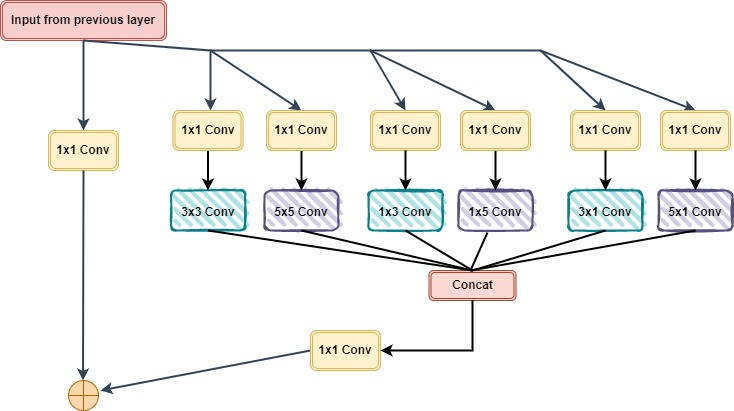

In [ ]:
from IPython.display import Image
Image(F'/content/drive/MyDrive/Colab Notebooks/Computer Vision/steel defects segmentation/Inception-Res-U-Net-block.jpg')

In [ ]:
from torch import nn
from torch.utils.data import DataLoader
from functools import reduce

In [ ]:
def get_activation(activation: str):
    if activation == 'relu':
        return nn.ReLU()
    elif activation == 'leaky':
        return nn.LeakyReLU(negative_slope=0.1)
    elif activation == 'elu':
        return nn.ELU()

In [ ]:
def crop(encoded_fmaps, x):
    _, _, H, W = x.shape
    encoded_fmaps = transforms.CenterCrop([H, W])(encoded_fmaps)
    return encoded_fmaps

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_dep: int, out_dep: int, reduction: bool, activation: str):
        super(ConvBlock, self).__init__()

        self.reduction = reduction
        self.activation = activation

        self.conv_reg_1 = nn.Conv2d(out_dep, out_dep*2, kernel_size = (3,3), stride = (1,1), padding = 1)
        self.conv_reg_2 = nn.Conv2d(out_dep, out_dep*2, kernel_size = (5,5), stride = (1,1), padding = 2)
        self.conv_horizontal_1 = nn.Conv2d(out_dep, out_dep*2, kernel_size = (1,3), stride = (1,1), padding = (0,1))
        self.conv_horizontal_2 = nn.Conv2d(out_dep, out_dep*2, kernel_size = (1,5), stride = (1,1), padding = (0,2))
        self.conv_vertical_1 = nn.Conv2d(out_dep, out_dep*2, kernel_size = (3,1), stride = (1,1), padding = (1,0))
        self.conv_vertical_2 = nn.Conv2d(out_dep, out_dep*2, kernel_size = (5,1), stride = (1,1), padding = (2,0))
        
        self.conv_project_pre = nn.Conv2d(in_dep, out_dep, kernel_size = (1,1), stride = (1,1), padding = 0)
        self.conv_project_post = nn.Conv2d(out_dep*4, out_dep*2, kernel_size = (1,1), stride = (1,1), padding = 0, groups = 2)
        self.conv_filter = nn.Conv2d(out_dep*6, out_dep*3, kernel_size = (1,1), stride = (1,1), padding = 0, groups = 3)
        
        if self.reduction == True:
            self.conv_map = nn.Conv2d(in_dep, out_dep*3, kernel_size = (1,1), stride = (1,1), padding = 0)
        else:
            self.conv_map = nn.Sequential(nn.Conv2d(out_dep*3, out_dep*2, kernel_size = (1,1), stride = (1,1), padding = 0),
                                          nn.BatchNorm2d(out_dep*2),
                                          get_activation(self.activation),
                                          nn.Conv2d(out_dep*2, out_dep, kernel_size = (1,1), stride = (1,1), padding = 0),
                                          nn.BatchNorm2d(out_dep),
                                          get_activation(self.activation),
                                          nn.Conv2d(out_dep, in_dep, kernel_size = (1,1), stride = (1,1), padding = 0)
                                          )
    
    def forward(self, x):
        xa1 = self.conv_reg_1(self.conv_project_pre(x))
        xa2 = self.conv_horizontal_1(self.conv_project_pre(x))
        xa3 = self.conv_vertical_1(self.conv_project_pre(x))
        xb1 = self.conv_reg_2(self.conv_project_pre(x))
        xb2 = self.conv_horizontal_2(self.conv_project_pre(x))
        xb3 = self.conv_vertical_2(self.conv_project_pre(x))
        x_f1 = torch.cat((xa1, xb1), 1)
        x_f2 = torch.cat((xa2, xb2), 1)
        x_f3 = torch.cat((xa3, xb3), 1)
        x_f1 = self.conv_project_post(x_f1)
        x_f2 = self.conv_project_post(x_f2)
        x_f3 = self.conv_project_post(x_f3)
        x_f = torch.cat((x_f1, x_f2, x_f3), 1)
        x_f = self.conv_filter(x_f)
        if self.reduction == True:
            x_map = self.conv_map(x)
            x = reduce(torch.Tensor.add_, [x_f, x_map])
        else:
            x_f = self.conv_map(x_f)
            x = reduce(torch.Tensor.add_, [x_f, x])
        return x

In [ ]:
class ConvTransposeBlock(nn.Module):
    def __init__(self, in_dep: int, out_dep: int, expansion: bool, activation: str):
        super(ConvTransposeBlock, self).__init__()

        self.expansion = expansion
        self.activation = activation

        self.conv_reg_1 = nn.ConvTranspose2d(out_dep, out_dep*2, kernel_size = (3,3), stride = (1,1), padding = 1)
        self.conv_reg_2 = nn.ConvTranspose2d(out_dep, out_dep*2, kernel_size = (5,5), stride = (1,1), padding = 2)
        self.conv_horizontal_1 = nn.ConvTranspose2d(out_dep, out_dep*2, kernel_size = (1,3), stride = (1,1), padding = (0,1))
        self.conv_horizontal_2 = nn.ConvTranspose2d(out_dep, out_dep*2, kernel_size = (1,5), stride = (1,1), padding = (0,2))
        self.conv_vertical_1 = nn.ConvTranspose2d(out_dep, out_dep*2, kernel_size = (3,1), stride = (1,1), padding = (1,0))
        self.conv_vertical_2 = nn.ConvTranspose2d(out_dep, out_dep*2, kernel_size = (5,1), stride = (1,1), padding = (2,0))

        self.conv_project_pre = nn.ConvTranspose2d(in_dep, out_dep, kernel_size = (1,1), stride = (1,1), padding = 0)
        self.conv_project_post = nn.ConvTranspose2d(out_dep*4, out_dep*2, kernel_size = (1,1), stride = (1,1), padding = 0, groups = 2)
        self.conv_filter = nn.ConvTranspose2d(out_dep*6, out_dep*3, kernel_size = (1,1), stride = (1,1), padding = 0, groups = 3)

        if self.expansion == True:
            self.conv_rescale = nn.Sequential(nn.ConvTranspose2d(out_dep*3, out_dep*2, kernel_size = (1,1), stride = (1,1), padding = 0),
                                              nn.BatchNorm2d(out_dep*2),
                                              get_activation(self.activation),
                                              nn.ConvTranspose2d(out_dep*2, out_dep, kernel_size = (1,1), stride = (1,1), padding = 0),
                                              nn.BatchNorm2d(out_dep),
                                              get_activation(self.activation)
                                              )
            self.conv_map = nn.ConvTranspose2d(in_dep, out_dep, kernel_size = (1,1), stride = (1,1), padding = 0)
        else:
            self.conv_map = nn.ConvTranspose2d(out_dep*3, in_dep, kernel_size = (1,1), stride = (1,1), padding = 0)

    def forward(self, x):
        xa1 = self.conv_reg_1(self.conv_project_pre(x))
        xa2 = self.conv_horizontal_1(self.conv_project_pre(x))
        xa3 = self.conv_vertical_1(self.conv_project_pre(x))
        xb1 = self.conv_reg_2(self.conv_project_pre(x))
        xb2 = self.conv_horizontal_2(self.conv_project_pre(x))
        xb3 = self.conv_vertical_2(self.conv_project_pre(x))
        x_f1 = torch.cat((xa1, xb1), 1)
        x_f2 = torch.cat((xa2, xb2), 1)
        x_f3 = torch.cat((xa3, xb3), 1)
        x_f1 = self.conv_project_post(x_f1)
        x_f2 = self.conv_project_post(x_f2)
        x_f3 = self.conv_project_post(x_f3)
        x_f = torch.cat((x_f1, x_f2, x_f3), 1)
        x_f = self.conv_filter(x_f)
        if self.expansion == True:
            x_f = self.conv_rescale(x_f)
            x_map = self.conv_map(x)
            x = reduce(torch.Tensor.add_, [x_f, x_map])
        else:
            x_f = self.conv_map(x_f)
            x = reduce(torch.Tensor.add_, [x_f, x])
        return x

In [ ]:
class DownSample(nn.Module):

    def __init__(self, activation: str = 'relu'):
      
        super(DownSample, self).__init__()
        self.activation = activation

        ## model layer 1
        self.res1 = nn.Conv2d(3, 16, kernel_size = (1,1), stride = (1,1), padding = 0)
        self.conv1 = ConvBlock(3, 16, True, self.activation)
        self.norm1a = nn.BatchNorm2d(48)
        self.act1 = get_activation(self.activation)
        self.pool1 = nn.MaxPool2d((2,2))
        self.map1 = nn.Conv2d(48, 32, kernel_size = (1,1), stride = (1,1), padding = 0)
        self.norm1 = nn.BatchNorm2d(32)
        ## model layer 2
        self.res2 = ConvBlock(32, 32, False, self.activation)
        self.conv2 = ConvBlock(32, 64, True, self.activation)
        self.norm2a = nn.BatchNorm2d(32)
        self.norm2b = nn.BatchNorm2d(192)
        self.act2 = get_activation(self.activation)
        self.pool2 = nn.MaxPool2d((2,2))
        self.map2 = nn.Conv2d(192, 128, kernel_size = (1,1), stride = (1,1), padding = 0)
        self.norm2 = nn.BatchNorm2d(128)
        ## model layer 3
        self.res3 = ConvBlock(128, 128, False, self.activation)
        self.conv3 = ConvBlock(128, 256, True, self.activation)
        self.norm3a = nn.BatchNorm2d(128)
        self.norm3b = nn.BatchNorm2d(768)
        self.act3 = get_activation(self.activation)
        self.pool3 = nn.MaxPool2d((2,2))
        self.map3 = nn.Conv2d(768, 512, kernel_size = (1,1), stride = (1,1), padding = 0)
        self.norm3 = nn.BatchNorm2d(512)
        ## model layer 4
        self.res4 = nn.Conv2d(512, 1024, kernel_size = (1,1), stride = (1,1), padding = 0)
        self.act4 = get_activation(self.activation)
        self.norm4 = nn.BatchNorm2d(1024)

    def forward(self, x):
        skip_connected_layers = []
        x_reserve = self.res1(x)
        skip_connected_layers.append(x_reserve)
        x = self.act1(self.norm1(self.map1(self.pool1(self.act1(self.norm1a(self.conv1(x)))))))
        skip_connected_layers.append(x)
        x = self.act2(self.norm2(self.map2(self.pool2(self.act2(self.norm2b(self.conv2(self.act2(self.norm2a(self.res2(x))))))))))
        skip_connected_layers.append(x)
        x = self.act3(self.norm3(self.map3(self.pool3(self.act3(self.norm3b(self.conv3(self.act3(self.norm3a(self.res3(x))))))))))
        skip_connected_layers.append(x)
        x = self.act4(self.norm4(self.res4(x)))
        return x, skip_connected_layers

In [ ]:
class UpSample(nn.Module):
    def __init__(self, activation: str = 'relu'):
      
        super(UpSample, self).__init__()
        self.activation = activation

        ## model layer 1
        self.upconv1 = ConvTransposeBlock(1024, 512, True, self.activation)
        self.act1 = get_activation(self.activation)
        self.norm1 = nn.BatchNorm2d(512)
        ## model layer 2
        self.upconv2a = ConvTransposeBlock(1024, 512, True, self.activation)
        self.upconv2b = ConvTransposeBlock(512, 256, True, self.activation)
        self.upconv2c = ConvTransposeBlock(256, 128, True, self.activation)
        self.act2 = get_activation(self.activation)
        self.norm2a = nn.BatchNorm2d(512)
        self.norm2b = nn.BatchNorm2d(256)
        self.norm2c = nn.BatchNorm2d(128)
        ## model layer 3
        self.upconv3a = ConvTransposeBlock(256, 128, True, self.activation)
        self.upconv3b = ConvTransposeBlock(128, 64, True, self.activation)
        self.upconv3c = ConvTransposeBlock(64, 32, True, self.activation)
        self.act3 = get_activation(self.activation)
        self.norm3a = nn.BatchNorm2d(128)
        self.norm3b = nn.BatchNorm2d(64)
        self.norm3c = nn.BatchNorm2d(32)
        ## model layer 4
        self.upconv4a = ConvTransposeBlock(64, 32, True, self.activation)
        self.upconv4b = ConvTransposeBlock(32, 16, True, self.activation)
        self.act4 = get_activation(self.activation)
        self.norm4a = nn.BatchNorm2d(32)
        self.norm4b = nn.BatchNorm2d(16)
        ## output layers
        self.upconv5a = ConvTransposeBlock(32, 16, True, self.activation)
        self.upconv5b = nn.ConvTranspose2d(16, 5, kernel_size = (1,1), stride = (1,1), padding = 0)
        self.act5 = get_activation(self.activation)
        self.norm5 = nn.BatchNorm2d(16)
        self.out = nn.ConvTranspose2d(5, 5, kernel_size = (1,1), stride = (1,1), padding = 0, groups = 5)
        
    def forward(self, encoder_features, x):
        x = self.act1(self.norm1(self.upconv1(x)))
        enc_layer1 = crop(encoder_features[3], x)
        x = torch.cat((enc_layer1, x), 1)
        x = self.act2(self.norm2c(self.upconv2c(self.act2(self.norm2b(self.upconv2b(self.act2(self.norm2a(self.upconv2a(x)))))))))
        x = nn.functional.interpolate(x, scale_factor=2, mode='nearest')
        enc_layer2 = crop(encoder_features[2], x)
        x = torch.cat((enc_layer2, x), 1)
        x = self.act3(self.norm3c(self.upconv3c(self.act3(self.norm3b(self.upconv3b(self.act3(self.norm3a(self.upconv3a(x)))))))))
        x = nn.functional.interpolate(x, scale_factor=2, mode='nearest')
        enc_layer3 = crop(encoder_features[1], x)
        x = torch.cat((enc_layer3, x), 1)
        x = self.act4(self.norm4b(self.upconv4b(self.act4(self.norm4a(self.upconv4a(x))))))
        x = nn.functional.interpolate(x, scale_factor=2, mode='nearest')
        enc_layer4 = crop(encoder_features[0], x)
        x = torch.cat((enc_layer4, x), 1)
        x = self.out(self.upconv5b(self.act5(self.norm5(self.upconv5a(x)))))
        return x

In [ ]:
class BranchConv_UNet(nn.Module):
    def __init__(self, activation: str = 'relu'):
        super(BranchConv_UNet, self).__init__()
        self.activation = activation
        self.encoder = DownSample(self.activation)
        self.decoder = UpSample(self.activation)

    def forward(self, x):
        x, skip_features = self.encoder(x)
        x = self.decoder(skip_features, x)
        return x

In [ ]:
class WGAN_Discriminator(nn.Module):
    def __init__(self, activation: str = 'relu'):
        super(WGAN_Discriminator, self).__init__()
        self.activation = activation

        ## model layer 1
        self.res1 = nn.Conv2d(5, 16, kernel_size = (1,1), stride = (1,1), padding = 0)
        self.conv1 = ConvBlock(5, 16, True, self.activation)
        self.pool1 = nn.MaxPool2d((2,2))
        self.map1 = nn.Conv2d(48, 32, kernel_size = (1,1), stride = (1,1), padding = 0)
        self.act1 = get_activation(self.activation)
        self.norm1a = nn.BatchNorm2d(48)
        self.norm1b = nn.BatchNorm2d(32)
        ## model layer 2
        self.res2 = ConvBlock(32, 32, False, self.activation)
        self.conv2 = ConvBlock(32, 64, True, self.activation)
        self.pool2 = nn.MaxPool2d((2,2))
        self.map2 = nn.Conv2d(192, 128, kernel_size = (1,1), stride = (1,1), padding = 0)
        self.act2 = get_activation(self.activation)
        self.norm2a = nn.BatchNorm2d(192)
        self.norm2b = nn.BatchNorm2d(128)
        ## model layer 3
        self.res3 = ConvBlock(128, 128, False, self.activation)
        self.conv3 = ConvBlock(128, 256, True, self.activation)
        self.pool3 = nn.MaxPool2d((2,2))
        self.map3 = nn.Conv2d(768, 512, kernel_size = (1,1), stride = (1,1), padding = 0)
        self.act3 = get_activation(self.activation)
        self.norm3a = nn.BatchNorm2d(768)
        self.norm3b = nn.BatchNorm2d(512)
        ## feed-forward layer
        self.ff1 = nn.Conv1d(1, 1, kernel_size = 11, stride = 10, padding = 5)
        self.ff2 = nn.Conv1d(1, 1, kernel_size = 1, stride = 1, padding = 0)
        self.ffd1 = nn.Linear(20480, 2048)
        self.ffd2 = nn.Linear(2048, 512)
        self.ffd3 = nn.Linear(512, 128)
        self.ffd4 = nn.Linear(128, 32)
        self.ffd5 = nn.Linear(32, 1)
        self.ffact = get_activation(self.activation)
        self.ffdrop = nn.Dropout(0.2)
        self.flatten = nn.Flatten()
        self.ffnorm1 = nn.BatchNorm1d(2048)
        self.ffnorm2 = nn.BatchNorm1d(512)
        self.ffnorm3 = nn.BatchNorm1d(128)
        self.ffnorm4 = nn.BatchNorm1d(32)

    def forward(self, x):
        x = self.act1(self.norm1b(self.map1(self.pool1(self.act1(self.norm1a(self.conv1(self.res1(x)))))))
        x = self.act2(self.norm2b(self.map2(self.pool2(self.act2(self.norm2a(self.conv2(self.res2(x)))))))
        x = self.act3(self.norm3b(self.map3(self.pool3(self.act3(self.norm3a(self.conv3(self.res3(x)))))))
        x = self.flatten(x)
        x = x.view(-1, 1, x.size()[1])
        x = self.ffact(self.ff2(self.ffact(self.ff1(x))))
        x = self.flatten(x)
        x = self.ffdrop(self.ffnorm1(self.ffact(self.ffd1(x))))
        x = self.ffdrop(self.ffnorm2(self.ffact(self.ffd2(x))))
        x = self.ffdrop(self.ffnorm3(self.ffact(self.ffd3(x))))
        x = self.ffdrop(self.ffnorm4(self.ffact(self.ffd4(x))))
        x = self.ffd5(x)
        return x

In [ ]:
## U-Net model specification
unet_model = BranchConv_UNet(activation="leaky")
unet_model = unet_model.cuda()
optimizer = torch.optim.Adam(unet_model.parameters(), lr = 1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)

In [ ]:
## U-Net WGAN-GP model specification
generator = BranchConv_UNet(activation="leaky")
generator = generator.cuda()
discriminator = WGAN_Discriminator(activation="leaky")
discriminator = discriminator.cuda()
generator_optimizer = torch.optim.Adam(generator.parameters(), lr = 5e-4)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr = 5e-5)

In [ ]:
class TrainingSpec_UNet:

    def __init__(self, train_data, unet_model, epochs, batches, optimizer, scheduler):
        super(TrainingSpec_UNet, self).__init__()
        ## dataloaders
        self.train_data = train_data
        self.traindataloader = DataLoader(self.train_data['train'], batch_size = batches, shuffle=True)
        self.valdataloader = DataLoader(self.train_data['val'], batch_size = batches, shuffle=True)
        ## model
        self.unet_model = unet_model
        ## training specs
        self.epochs = epochs
        self.batches = batches
        self.optimizer = optimizer
        self.scheduler = scheduler
        ## training logs
        self.train_loss_hist = []
        self.train_metric = []
        self.val_loss_hist = []
        self.val_metric = []
        self.id_batches = None

    def loss_fn(self, input, target):

        ## Cross-Entropy Loss
        _, labels = torch.max(target, dim = 1)
        weights = torch.tensor([400.0, 480.0, 80.0, 40.0, 1.0]).cuda()
        base_loss = nn.CrossEntropyLoss(weight = weights)(input, labels)

        ## Dice Loss
        pos = torch.argmax(input, dim=1, keepdims=True)
        input = torch.zeros_like(input).scatter_(1, pos, 1.)
        input = input[:,0:4,:,:]
        target = target[:,0:4,:,:]
        smooth = 1.
        num = input.size(0)
        input_flat = input.view(num, -1)
        target_flat = target.view(num, -1)
        intersection = (input_flat * target_flat).sum()
        dice_loss = 1 - ((2. * intersection + smooth) / (input_flat.sum() + target_flat.sum() + smooth))

        return 0.2 * base_loss + 0.8 * dice_loss

    def dice_coefficient(self, pred, target):
        num = pred.size(0)
        pos = torch.argmax(pred, dim=1, keepdims=True)
        pred = torch.zeros_like(pred).scatter_(1, pos, 1.)
        pred = pred[:,0:4,:,:]
        target = target[:,0:4,:,:]
        t1 = pred.view(num, -1).float()
        t2 = target.view(num, -1).float()
        intersection = (t1 * t2).sum().float()
        dice = (2. * intersection) / (t1.sum() + t2.sum())
        return dice.item()
    
    def multiclass_acc(self, y_pred, y_test):
        num = y_pred.size(2) * y_pred.size(3)
        y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        _, y_test_tags = torch.max(y_test, dim = 1)
        correct_pred = (y_pred_tags == y_test_tags).float()
        acc = correct_pred.sum() / (len(correct_pred) * num)
        return acc.item()

    def evaluate(self):
        with torch.no_grad():
            self.unet_model.eval()
            val_acc = []
            val_dice = []
            for id_batch, (x_batch, y_batch) in enumerate(self.valdataloader):
                x_batch, y_batch = x_batch.cuda(), y_batch.cuda()
                y_batch_pred = self.unet_model(x_batch)
                loss = self.loss_fn(y_batch_pred, y_batch)
                dice = self.dice_coefficient(y_batch_pred, y_batch)
                acc = self.multiclass_acc(y_batch_pred, y_batch)
                val_dice.append(dice)
                val_acc.append(acc)
        return loss.item(), val_dice, val_acc

    def train(self, start_epoch=0):
        for epoch in range(start_epoch, self.epochs + start_epoch):
            self.unet_model.train()
            batch_acc = []
            batch_dice = []
            for id_batch, (x_batch, y_batch) in enumerate(self.traindataloader):
                x_batch, y_batch = x_batch.cuda(), y_batch.cuda()
                self.optimizer.zero_grad()
                y_batch_pred = self.unet_model(x_batch)
                loss = self.loss_fn(y_batch_pred, y_batch)
                loss.backward()
                self.optimizer.step()

                train_acc = self.multiclass_acc(y_batch_pred, y_batch)
                train_dice = self.dice_coefficient(y_batch_pred, y_batch)
                batch_acc.append(train_acc)
                batch_dice.append(train_dice)

                self.id_batches = id_batch

            val_loss, val_dice, val_acc = self.evaluate()
            self.scheduler.step(val_loss)
                
            train_loss, current = loss.item(), (id_batch+1) * len(x_batch)
            print(f"Epoch {epoch + 1} --- " + \
                  f"train_loss: {train_loss:>5f} val_loss: {val_loss:>5f} | " + \
                  f"train_dice: {np.mean(batch_dice):>4f} val_dice: {np.mean(val_dice):>4f} | " + \
                  f"train_acc: {np.mean(batch_acc):>4f} val_acc: {np.mean(val_acc):>4f} | " + \
                  f"[batches iterated: {current:>5d}]")

            self.train_loss_hist.append(train_loss)
            self.val_loss_hist.append(val_loss)
            self.train_metric.append([np.mean(batch_dice), np.max(batch_dice), np.mean(batch_acc), np.max(batch_acc)])
            self.val_metric.append([np.mean(val_dice), np.max(val_dice), np.mean(val_acc), np.max(val_acc)])

In [ ]:
class TrainingSpec_UNet_GAN:

    def __init__(self, generator, discriminator, generator_opt, discriminator_opt, gradient_penalty, 
                 train_data, epochs, batches, weight_clip, n_critic, scheduler):
        super(TrainingSpec_UNet_GAN, self).__init__()
        ## dataloaders
        self.train_data = train_data
        self.traindataloader = DataLoader(self.train_data['train'], batch_size = batches, shuffle=True)
        self.valdataloader = DataLoader(self.train_data['val'], batch_size = batches, shuffle=True)
        ## models
        self.generator = generator
        self.discriminator = discriminator
        ## training specs
        self.epochs = epochs
        self.batches = batches
        self.weight_clip = weight_clip
        self.n_critic = n_critic
        self.gradient_penalty = gradient_penalty
        self.generator_optimizer = generator_opt
        self.discriminator_optimizer = discriminator_opt
        self.scheduler = scheduler
        self.generator_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.generator_optimizer, mode='min',
        factor=0.75, patience=5, min_lr=5e-6)
        self.discriminator_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.discriminator_optimizer, mode='min',
        factor=0.75, patience=5, min_lr=5e-6)

        self.train_loss_hist = []
        self.train_metric = []
        self.val_loss_hist = []
        self.val_metric = []
        self.id_batches = None

    def dice_coefficient(self, pred, target):
        num = pred.size(0)
        pos = torch.argmax(pred, dim=1, keepdims=True)
        pred = torch.zeros_like(pred).scatter_(1, pos, 1.)
        pred = pred[:,0:4,:,:]
        target = target[:,0:4,:,:]
        t1 = pred.view(num, -1).float()
        t2 = target.view(num, -1).float()
        intersection = (t1 * t2).sum().float()
        dice = (2. * intersection) / (t1.sum() + t2.sum())
        return dice.item()

    def multiclass_acc(self, y_pred, y_test):
        num = y_pred.size(2) * y_pred.size(3)
        y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        _, y_test_tags = torch.max(y_test, dim = 1)
        correct_pred = (y_pred_tags == y_test_tags).float()
        acc = correct_pred.sum() / (len(correct_pred) * num)
        return acc.item()

    def g_loss_fn(self, input, target):
      
        ## Cross-Entropy Loss
        _, labels = torch.max(target, dim = 1)
        weights = torch.tensor([400.0, 480.0, 80.0, 40.0, 1.0]).cuda()
        base_loss = nn.CrossEntropyLoss(weight = weights)(input, labels)

        ## Dice Loss
        pos = torch.argmax(input, dim=1, keepdims=True)
        input = torch.zeros_like(input).scatter_(1, pos, 1.)
        input = input[:,0:4,:,:]
        target = target[:,0:4,:,:]
        smooth = 1.
        num = input.size(0)
        input_flat = input.view(num, -1)
        target_flat = target.view(num, -1)
        intersection = (input_flat * target_flat).sum()
        dice_loss = 1 - ((2. * intersection + smooth) / (input_flat.sum() + target_flat.sum() + smooth))

        return 0.2 * base_loss + 0.8 * dice_loss

    def evaluate(self):
        with torch.no_grad():
            self.generator.eval()
            self.discriminator.eval()
            val_dice = []
            val_acc = []
            for id_batch, (x_batch, y_batch) in enumerate(self.valdataloader):
                x_batch, y_batch = x_batch.cuda(), y_batch.float().cuda()
                y_batch_pred = self.generator(x_batch)
                gen_y = self.discriminator(y_batch_pred)
                raw_y = self.discriminator(y_batch)
                d_loss = torch.mean(raw_y) - torch.mean(gen_y)
                g_loss = -torch.mean(gen_y) * 0.05 + self.g_loss_fn(y_batch_pred, y_batch) * 0.95
                dice = self.dice_coefficient(y_batch_pred, y_batch)
                acc = self.multiclass_acc(y_batch_pred, y_batch)
                val_dice.append(dice)
                val_acc.append(acc)
        return d_loss.item(), g_loss.item(), np.mean(val_dice), np.mean(val_acc)

    def compute_gradient_penalty(self, discriminator, gen_image, real_image):
        batch_size = real_image.size(0)
        alpha = torch.rand(batch_size, 1, 1, 1)
        alpha = alpha.expand(real_image.size())
        alpha = alpha.cuda()
        interpolation = alpha * real_image + (1 - alpha) * gen_image
        interpolation.requires_grad = True
        interp_critic = discriminator(interpolation)
        grad_outputs = torch.ones_like(interp_critic).cuda()
        gradient = torch.autograd.grad(inputs = interpolation,
                                       outputs = interp_critic,
                                       grad_outputs = grad_outputs,
                                       retain_graph = True,
                                       create_graph = True)[0]
        gradients = gradient.view(batch_size, -1)
        grad_norm = gradients.norm(2, 1)
        grad_pen = torch.mean((grad_norm - 1) ** 2)
        return grad_pen

    def train(self, accumulate_gradient, accumulation_steps, start_epoch = 0):
        for epoch in range(start_epoch, self.epochs + start_epoch):
            self.generator.train()
            self.discriminator.train()
            batch_dice = []
            batch_acc = []
            if accumulate_gradient != False:
                self.discriminator_optimizer.zero_grad()
                self.generator_optimizer.zero_grad()
            for id_batch, (x_batch, y_batch) in enumerate(self.traindataloader):
                x_batch, y_batch = x_batch.cuda(), y_batch.float().cuda()
                
                for n in range(self.n_critic):
                    if accumulate_gradient == False:
                        self.discriminator_optimizer.zero_grad()
                    ## discriminator update
                    segmentation = self.generator(x_batch).detach()
                    gen_y = self.discriminator(segmentation)
                    raw_y = self.discriminator(y_batch)

                    ## gradient penalty
                    if self.gradient_penalty == False:
                        discriminator_loss = torch.mean(raw_y) - torch.mean(gen_y)
                    else:
                        gp = self.compute_gradient_penalty(self.discriminator, segmentation, y_batch)
                        discriminator_loss = torch.mean(raw_y) - torch.mean(gen_y) + 10 * gp
                    discriminator_loss.backward()

                    if accumulate_gradient != False:
                        if (id_batch+1) % accumulation_steps == 0 or (id_batch+1) == len(self.traindataloader):
                            self.discriminator_optimizer.step()                  # update the weights only after accumulating k small batches
                            self.discriminator_optimizer.zero_grad()             # reset gradients for accumulation for the next large_batch
                    else:
                        self.discriminator_optimizer.step()

                    if self.gradient_penalty == False:
                        ## weight clipping
                        for p in self.discriminator.parameters():
                            p.data.clamp_(-self.weight_clip, self.weight_clip)

                ## generator update
                if accumulate_gradient == False:
                    self.generator_optimizer.zero_grad()
                segmentation = self.generator(x_batch)
                critics_gen_y = self.discriminator(segmentation)
                generator_loss = -torch.mean(critics_gen_y) * 0.05 + self.g_loss_fn(segmentation, y_batch) * 0.95
                generator_loss.backward()

                if accumulate_gradient != False:
                    if (id_batch+1) % accumulation_steps == 0 or (id_batch+1) == len(self.traindataloader):
                        self.generator_optimizer.step()                  # update the weights only after accumulating k small batches
                        self.generator_optimizer.zero_grad()             # reset gradients for accumulation for the next large_batch
                else:
                    self.generator_optimizer.step()
                    
                ## batch dice
                if accumulate_gradient != False:
                    if (id_batch+1) % accumulation_steps == 0 or (id_batch+1) == len(self.traindataloader):
                        segmentation = segmentation.detach()
                        mini_dice = self.dice_coefficient(segmentation, y_batch)
                        mini_acc = self.multiclass_acc(segmentation, y_batch)
                        batch_dice.append(mini_dice)
                        batch_acc.append(mini_acc)
                else:
                    segmentation = segmentation.detach()
                    mini_dice = self.dice_coefficient(segmentation, y_batch)
                    mini_acc = self.multiclass_acc(segmentation, y_batch)
                    batch_dice.append(mini_dice)
                    batch_acc.append(mini_acc)
                
                self.id_batches = id_batch
                ## if (id_batch+1) % 10 == 0:
                ##     print("Completed " + str(id_batch+1) + " Batches.")
                ## print(torch.cuda.memory_allocated()/1024/1024)

            ## gather loss & metrics
            val_d_loss, val_g_loss, val_dice, val_acc = self.evaluate()
            if self.scheduler == True:
                self.generator_scheduler.step(val_g_loss)
                self.discriminator_scheduler.step(val_d_loss)

            self.train_loss_hist.append([discriminator_loss, generator_loss])
            self.val_loss_hist.append([val_d_loss, val_g_loss])
            self.val_metric.append([val_dice, val_acc])
            
            self.train_metric.append([np.max(batch_dice), np.mean(batch_dice), np.max(batch_acc), np.mean(batch_acc)])
            current = (id_batch+1) * len(x_batch)

            print(f"Epoch {epoch + 1} ----- " + \
                  f"train_g_loss: {generator_loss:>5f} val_g_loss: {val_g_loss:>5f} | " + \
                  f"train_d_loss: {discriminator_loss:>5f} val_d_loss: {val_d_loss:>5f} | " + \
                  f"train_dice: {np.mean(batch_dice):>4f} val_dice: {val_dice:>4f} | " + \
                  f"train_acc: {np.mean(batch_acc):>4f} val_acc: {val_acc:>4f} | " + \
                  f"[batches iterated: {current:>4d}]")

In [ ]:
unet_pipeline = TrainingSpec_UNet(df_train, unet_model, 50, 16, optimizer, scheduler)

In [ ]:
unet_wgan_pipeline = TrainingSpec_UNet_GAN(generator = generator, discriminator = discriminator, 
                                           generator_opt = generator_optimizer, discriminator_opt = discriminator_optimizer,
                                           gradient_penalty = True, train_data = df_train, epochs = 10, batches = 16, 
                                           weight_clip = 0.01, n_critic = 5, scheduler = True)

#### **Evaluation:** ####

<br>

The plots of monitored training and validation dice coefficients between the UNet and the UNet-WGAN suggested an apparently faster learning boost observed for the UNet model within a range from around epoch 30 to around epoch 120. The validation dice coefficient of the UNet was flattened at around epoch 75, the model seemed to attain its capability limit. The dice coefficients of UNet-WGAN were relatively more fluctuating but kept gradually increasing. A gap between training and validation dice coefficients started to widen after approximately going through 75 epochs. 

From the evaluation on training, validation and testing sets, both models achieved over 77% dice coefficient. The UNet-WGAN model was seen milder overfitting as performing better in the validation set than the UNet model, but both had similar performance on the testing set achieving over 65% dice coefficient. The results reflected that the adversarial training mechanism helped alleviate the problem of over-capturing the training set's features that might lead to larger variance in prediction of defect masks.

As a reference, using the entire training set of 12,000 images, deeper models, and less overfitting, the training dice coefficient could exceed 90% and the testing dice coefficient generally could grow higher than 85%. Since in this test, only around 1/6 of all samples were used, the above results were perspicuous due to insufficient representation of the whole data distributions and exposure to specific defect class or normal conditions. 

In [ ]:
unet_log = pd.read_excel(F'/content/drive/MyDrive/Colab Notebooks/Computer Vision/steel defects segmentation/unet_logs.xlsx')
unet_wgan_log = pd.read_excel(F'/content/drive/MyDrive/Colab Notebooks/Computer Vision/steel defects segmentation/unet wgan_logs.xlsx')

In [ ]:
unet_log = unet_log[['Epoch','train_dice_modified', 'val_dice_modified']]
unet_log.columns = ['Epoch','UNet_train_dice','UNet_val_dice']
unet_log = pd.melt(unet_log, id_vars=['Epoch'], value_vars=['UNet_train_dice', 'UNet_val_dice'])
unet_wgan_log = unet_wgan_log[['Epoch','train_dice', 'val_dice']]
unet_wgan_log.columns = ['Epoch','UNet_GAN_train_dice','UNet_GAN_val_dice']
unet_wgan_log = pd.melt(unet_wgan_log, id_vars=['Epoch'], value_vars=['UNet_GAN_train_dice', 'UNet_GAN_val_dice'])
logs = pd.concat([unet_log, unet_wgan_log], axis=0)

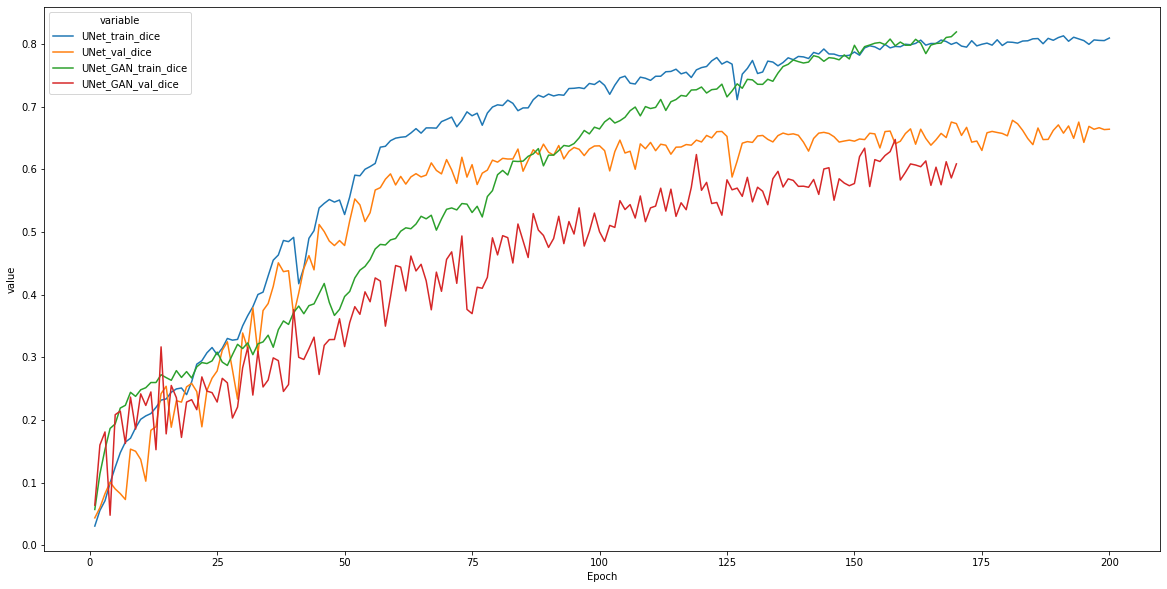

In [ ]:
plt.rcParams['figure.figsize'] = (20, 10)
seaborn.lineplot(data=logs.reset_index(drop=True), x="Epoch", y="value", hue="variable")

In [ ]:
## generate a transformed dataset for images and targets
from torchvision import transforms
from torch.utils import data

class transformed_data(data.Dataset):
    def __init__(self, img_path, mask_path):
        self.img = img_path    
        self.mask = mask_path

    def __getitem__(self, index):
        ## loading
        ls_img = sorted(os.listdir(self.img))
        ls_mask = sorted(os.listdir(self.mask))
        img_file_path = os.path.join(self.img, ls_img[index])
        img_tensor = torch.load(img_file_path)
        mask_file_path = os.path.join(self.mask, ls_mask[index])
        mask_numpy = torch.load(mask_file_path)
        mask_numpy = transforms.ToPILImage()(mask_numpy)
        mask_numpy = np.array(mask_numpy)
        ## normalization
        mean = transforms.ToTensor()(img_tensor).mean([1,2])
        std = transforms.ToTensor()(img_tensor).std([1,2])
        ## ToTensor() = scaled to 1/255
        ## Normalize = scaled to -1 to 1
        colors = np.array([[128,64,128],
                           [190,250,190],
                           [254,228,12],
                           [28,42,168]])
        ohe = np.zeros((*mask_numpy.shape[:2], len(colors)))
        for label, color in enumerate(colors):
            v = np.zeros(len(colors))
            v[label] = 1
            ohe[np.all(mask_numpy == color, axis=-1)] = v
        img_norm = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(64),
                    ## transforms.Normalize(mean, std)
        ])
        img_tensor = img_norm(img_tensor)
        mask_norm = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(64)
        ])
        mask_tensor = mask_norm(ohe)
        mask_tensor[mask_tensor > 0] = 1
        return img_tensor, mask_tensor

    def __len__(self):
        return len(os.listdir(self.img))

In [ ]:
df_train = transformed_data(img_path = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/steel defects segmentation/steel_image/subsample/train/',
                            mask_path = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/steel defects segmentation/steel_image/subsample/train_mask/')

In [ ]:
def dataset_split(dataset, val_split=0.1, random_state=None):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split, random_state=random_state)
    datasets = {}
    datasets['train'] = torch.utils.data.Subset(dataset, train_idx)
    datasets['val'] = torch.utils.data.Subset(dataset, val_idx)
    return datasets

In [ ]:
df_train = dataset_split(df_train, random_state=42)

In [ ]:
df_test = transformed_data(img_path = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/steel defects segmentation/steel_image/subsample/test/',
                           mask_path = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/steel defects segmentation/steel_image/subsample/test_mask/')

In [ ]:
## load saved model
checkpoint = torch.load(F'/content/drive/MyDrive/Colab Notebooks/Computer Vision/steel defects segmentation/steel_model/unet/checkpoint_model_170.pt')
unet_model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch_at = checkpoint['epoch']

In [ ]:
def dice_coefficient(pred, target):
    num = pred.size(0)
    t1 = pred.view(num, -1).float()
    t2 = target.view(num, -1).float()
    intersection = (t1 * t2).sum().float()
    dice = (2. * intersection) / (t1.sum() + t2.sum())
    return dice.item()
    
def multiclass_acc(y_pred_softmax, y_test):
    num = y_pred_softmax.size(2) * y_pred_softmax.size(3)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
    _, y_test_tags = torch.max(y_test, dim = 1)
    correct_pred = (y_pred_tags == y_test_tags).float()
    acc = correct_pred.sum() / (len(correct_pred) * num)
    return acc.item()

In [ ]:
## 4-mask evaluation on the unet model
unet_model.eval()
traindataloader = DataLoader(df_train['train'], batch_size = 1, shuffle=True)
train_acc = []
train_dice = []
train_pred = []
train_y = []
for id_batch, (x_batch, y_batch) in enumerate(traindataloader):
    x_batch, y_batch = x_batch.cuda(), y_batch.cuda()
    y_batch_pred = unet_model(x_batch)
    pos = torch.argmax(y_batch_pred, dim=1, keepdims=True)
    y_batch_pred_softmax = torch.zeros_like(y_batch_pred).scatter_(1, pos, 1.)
    y_batch_pred_softmax = y_batch_pred_softmax[:,0:4,:,:]
    dice = dice_coefficient(y_batch_pred_softmax, y_batch)
    acc = multiclass_acc(y_batch_pred_softmax, y_batch)
    train_dice.append(dice)
    train_acc.append(acc)
    train_pred.append(y_batch_pred_softmax)
    train_y.append(y_batch)

In [ ]:
unet_model.eval()
valdataloader = DataLoader(df_train['val'], batch_size = 1, shuffle=True)
val_acc = []
val_dice = []
val_pred = []
val_y = []
for id_batch, (x_batch, y_batch) in enumerate(valdataloader):
    x_batch, y_batch = x_batch.cuda(), y_batch.cuda()
    y_batch_pred = unet_model(x_batch)
    pos = torch.argmax(y_batch_pred, dim=1, keepdims=True)
    y_batch_pred_softmax = torch.zeros_like(y_batch_pred).scatter_(1, pos, 1.)
    y_batch_pred_softmax = y_batch_pred_softmax[:,0:4,:,:]
    dice = dice_coefficient(y_batch_pred_softmax, y_batch)
    acc = multiclass_acc(y_batch_pred_softmax, y_batch)
    val_dice.append(dice)
    val_acc.append(acc)
    val_pred.append(y_batch_pred_softmax)
    val_y.append(y_batch)

In [ ]:
unet_model.eval()
testdataloader = DataLoader(df_test, batch_size = 1, shuffle=True)
test_acc = []
test_dice = []
test_pred = []
test_y = []
for id_batch, (x_batch, y_batch) in enumerate(testdataloader):
    x_batch, y_batch = x_batch.cuda(), y_batch.cuda()
    y_batch_pred = unet_model(x_batch)
    pos = torch.argmax(y_batch_pred, dim=1, keepdims=True)
    y_batch_pred_softmax = torch.zeros_like(y_batch_pred).scatter_(1, pos, 1.)
    y_batch_pred_softmax = y_batch_pred_softmax[:,0:4,:,:]
    dice = dice_coefficient(y_batch_pred_softmax, y_batch)
    acc = multiclass_acc(y_batch_pred_softmax, y_batch)
    test_dice.append(dice)
    test_acc.append(acc)
    test_pred.append(y_batch_pred_softmax)
    test_y.append(y_batch)

In [ ]:
print("Mean Train Dice Coef:  " + str(round(np.mean(train_dice), 4)))
print("Mean Train Accuracy:  " + str(round(np.mean(train_acc), 4)))

Mean Train Dice Coef:  0.7779
Mean Train Accuracy:  0.9832


In [ ]:
print("Mean Validation Dice Coef:  " + str(round(np.mean(val_dice), 4)))
print("Mean Validation Accuracy:  " + str(round(np.mean(val_acc), 4)))

Mean Validation Dice Coef:  0.6812
Mean Validation Accuracy:  0.9736


In [ ]:
print("Mean Test Dice Coef:  " + str(round(np.mean(test_dice), 4)))
print("Mean Test Accuracy:  " + str(round(np.mean(test_acc), 4)))

Mean Test Dice Coef:  0.6581
Mean Test Accuracy:  0.9713


In [ ]:
train_pred_array = [x.cpu().numpy() for x in train_pred]
val_pred_array = [x.cpu().numpy() for x in val_pred]
test_pred_array = [x.cpu().numpy() for x in test_pred]
train_y_array = [x.cpu().numpy() for x in train_y]
val_y_array = [x.cpu().numpy() for x in val_y]
test_y_array = [x.cpu().numpy() for x in test_y]

In [ ]:
train_pred_array = np.concatenate(train_pred_array)
val_pred_array = np.concatenate(val_pred_array)
test_pred_array = np.concatenate(test_pred_array)
train_y_array = np.concatenate(train_y_array)
val_y_array = np.concatenate(val_y_array)
test_y_array = np.concatenate(test_y_array)

In [ ]:
train_pred_array = train_pred_array.reshape(train_pred_array.shape[0], train_pred_array.shape[2], train_pred_array.shape[3], 4)
val_pred_array = val_pred_array.reshape(val_pred_array.shape[0], val_pred_array.shape[2], val_pred_array.shape[3], 4)
test_pred_array = test_pred_array.reshape(test_pred_array.shape[0], test_pred_array.shape[2], test_pred_array.shape[3], 4)
train_y_array = train_y_array.reshape(train_y_array.shape[0], train_y_array.shape[2], train_y_array.shape[3], 4)
val_y_array = val_y_array.reshape(val_y_array.shape[0], val_y_array.shape[2], val_y_array.shape[3], 4)
test_y_array = test_y_array.reshape(test_y_array.shape[0], test_y_array.shape[2], test_y_array.shape[3], 4)

In [ ]:
def decode_image(image_array):
    out_list = []
    for n in range(len(image_array)):
        y = np.zeros((64, 400, 3))
        idx0 = np.dstack((np.where(image_array[n,:,:,0] == 1)[0], np.where(image_array[n,:,:,0] == 1)[1])).reshape(-1, 2)
        idx1 = np.dstack((np.where(image_array[n,:,:,1] == 1)[0], np.where(image_array[n,:,:,1] == 1)[1])).reshape(-1, 2)
        idx2 = np.dstack((np.where(image_array[n,:,:,2] == 1)[0], np.where(image_array[n,:,:,2] == 1)[1])).reshape(-1, 2)
        idx3 = np.dstack((np.where(image_array[n,:,:,3] == 1)[0], np.where(image_array[n,:,:,3] == 1)[1])).reshape(-1, 2)
        for x in range(len(idx0)):
          y[idx0[x,0], idx0[x,1], :] = np.array([128,64,128])
        for x in range(len(idx1)):
          y[idx1[x,0], idx1[x,1], :] = np.array([190,250,190])
        for x in range(len(idx2)):
          y[idx2[x,0], idx2[x,1], :] = np.array([254,228,12])
        for x in range(len(idx3)):
          y[idx3[x,0], idx3[x,1], :] = np.array([28,42,168])
        out_list.append(y.reshape(1,64,400,3))
    return np.concatenate(out_list)

In [ ]:
train_pred_2 = decode_image(train_pred_array)
val_pred_2 = decode_image(val_pred_array)
test_pred_2 = decode_image(test_pred_array)
train_y_2 = decode_image(train_y_array)
val_y_2 = decode_image(val_y_array)
test_y_2 = decode_image(test_y_array)

In [ ]:
import random
rand_idx1 = random.sample(range(len(train_pred_2)), 10)
rand_idx2 = random.sample(range(len(val_pred_2)), 10)
rand_idx3 = random.sample(range(len(test_pred_2)), 10)

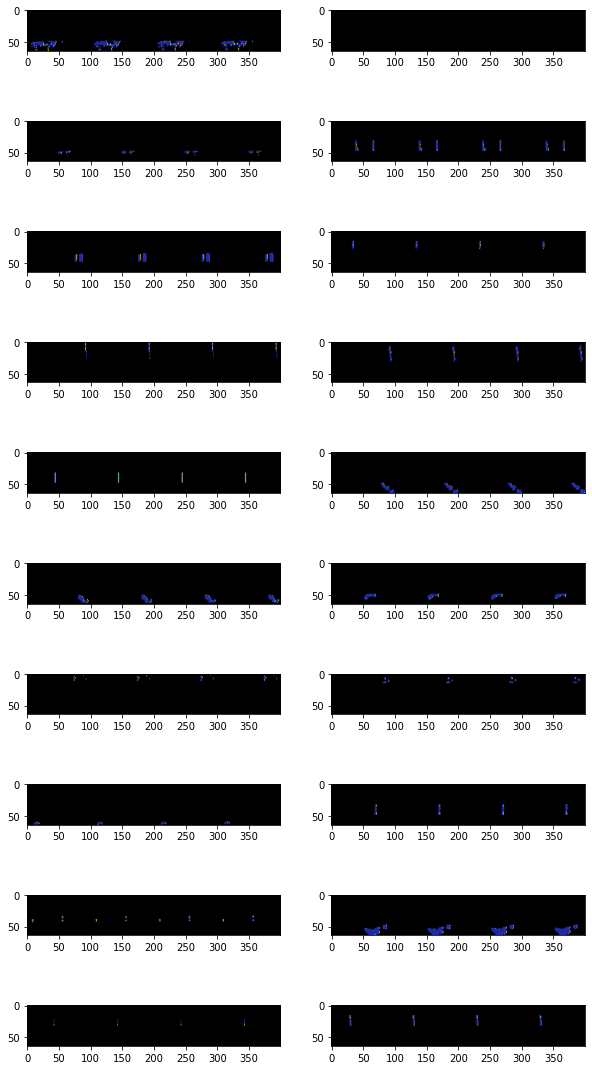

In [ ]:
plt.rcParams["figure.figsize"] = (10,20)
f, ax = plt.subplots(ncols=2, nrows=10)
for k in range(len(rand_idx1)):
    ax[k,0].imshow(train_y_2[rand_idx1[k]].astype(int).reshape(64,400,3))
    ax[k,1].imshow(train_pred_2[rand_idx1[k]].astype(int).reshape(64,400,3))

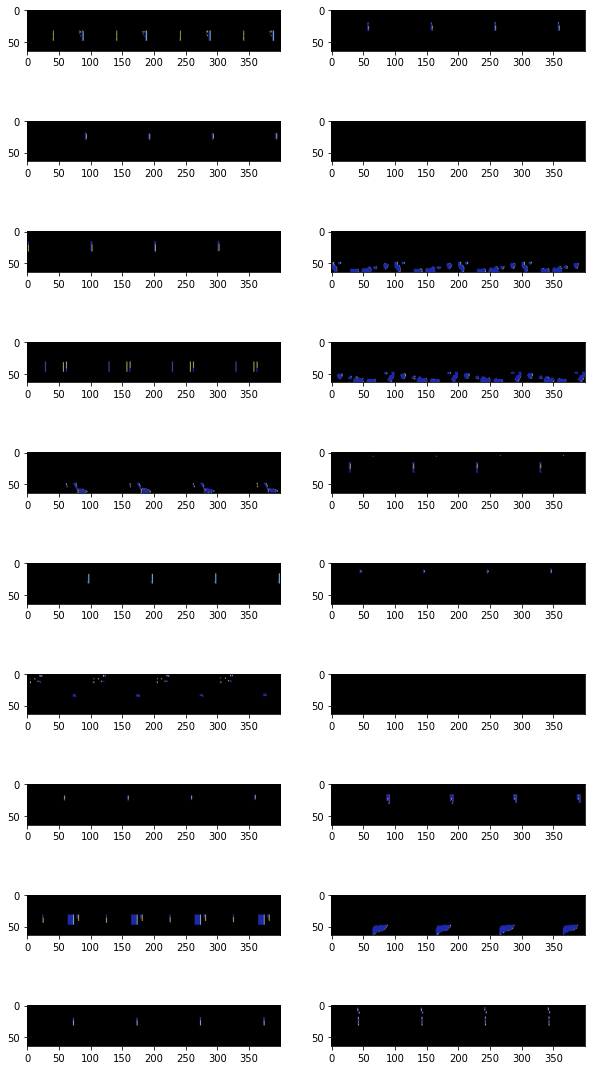

In [ ]:
plt.rcParams["figure.figsize"] = (10,20)
f, ax = plt.subplots(ncols=2, nrows=10)
for k in range(len(rand_idx3)):
    ax[k,0].imshow(test_y_2[rand_idx3[k]].astype(int).reshape(64,400,3))
    ax[k,1].imshow(test_pred_2[rand_idx3[k]].astype(int).reshape(64,400,3))

In [ ]:
## unet wgan evaluation
generator.eval()
traindataloader = DataLoader(df_train['train'], batch_size = 1, shuffle=True)
train_acc = []
train_dice = []
train_pred = []
train_y = []
for id_batch, (x_batch, y_batch) in enumerate(traindataloader):
    x_batch, y_batch = x_batch.cuda(), y_batch.cuda()
    y_batch_pred = generator(x_batch)
    pos = torch.argmax(y_batch_pred, dim=1, keepdims=True)
    y_batch_pred_softmax = torch.zeros_like(y_batch_pred).scatter_(1, pos, 1.)
    y_batch_pred_softmax = y_batch_pred_softmax[:,0:4,:,:]
    dice = dice_coefficient(y_batch_pred_softmax, y_batch)
    acc = multiclass_acc(y_batch_pred_softmax, y_batch)
    train_dice.append(dice)
    train_acc.append(acc)
    train_pred.append(y_batch_pred_softmax)

In [ ]:
generator.eval()
valdataloader = DataLoader(df_train['val'], batch_size = 1, shuffle=True)
val_acc = []
val_dice = []
val_pred = []
val_y = []
for id_batch, (x_batch, y_batch) in enumerate(valdataloader):
    x_batch, y_batch = x_batch.cuda(), y_batch.cuda()
    y_batch_pred = generator(x_batch)
    pos = torch.argmax(y_batch_pred, dim=1, keepdims=True)
    y_batch_pred_softmax = torch.zeros_like(y_batch_pred).scatter_(1, pos, 1.)
    y_batch_pred_softmax = y_batch_pred_softmax[:,0:4,:,:]
    dice = dice_coefficient(y_batch_pred_softmax, y_batch)
    acc = multiclass_acc(y_batch_pred_softmax, y_batch)
    val_dice.append(dice)
    val_acc.append(acc)
    val_pred.append(y_batch_pred_softmax)

In [ ]:
generator.eval()
testdataloader = DataLoader(df_test, batch_size = 1, shuffle=True)
test_acc = []
test_dice = []
test_pred = []
test_y = []
for id_batch, (x_batch, y_batch) in enumerate(testdataloader):
    x_batch, y_batch = x_batch.cuda(), y_batch.cuda()
    y_batch_pred = generator(x_batch)
    pos = torch.argmax(y_batch_pred, dim=1, keepdims=True)
    y_batch_pred_softmax = torch.zeros_like(y_batch_pred).scatter_(1, pos, 1.)
    y_batch_pred_softmax = y_batch_pred_softmax[:,0:4,:,:]
    dice = dice_coefficient(y_batch_pred_softmax, y_batch)
    acc = multiclass_acc(y_batch_pred_softmax, y_batch)
    test_dice.append(dice)
    test_acc.append(acc)
    test_pred.append(y_batch_pred_softmax)

In [ ]:
print("Mean Train Dice Coef:  " + str(0.7916))
print("Mean Train Accuracy:  " + str(0.9837))

Mean Train Dice Coef:  0.7916
Mean Train Accuracy:  0.9837


In [ ]:
print("Mean Validation Dice Coef:  " + str(0.7329))
print("Mean Validation Accuracy:  " + str(0.9741))

Mean Validation Dice Coef:  0.7329
Mean Validation Accuracy:  0.9741


In [ ]:
print("Mean Test Dice Coef:  " + str(0.6672))
print("Mean Test Accuracy:  " + str(0.9696))

Mean Test Dice Coef:  0.6672
Mean Test Accuracy:  0.9696
